# MACHINE LEARNING MODELS

LOADING ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#from functions import run_exps

import warnings
warnings.filterwarnings('ignore') 

In [75]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
        '''
        Lightweight script to test many models and find winners
        :param X_train: training split
        :param y_train: training target vector
        :param X_test: test split
        :param y_test: test target vector
        :return: DataFrame of predictions
        '''
        
        dfs = []

        #dt = DecisionTreeClassifier(max_depth=1)

        models = [
                ('LogReg', LogisticRegression()), 
                ('RF', RandomForestClassifier()),
                ('KNN', KNeighborsClassifier()),
                ('GNB', GaussianNB()),
                ('XGB', XGBClassifier()),
                ('ADA', AdaBoostClassifier())
                ]
        results = []
        names = []

        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

        target_names = ['malignant', 'benign']

        for name, model in models:
                kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
                cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
                clf = model.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                print(name)
                print(classification_report(y_test, y_pred, target_names=target_names))
                results.append(cv_results)
                names.append(name)
                this_df = pd.DataFrame(cv_results)
                this_df['model'] = name
                dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
        return final

In [2]:
train = pd.read_csv('./data/cleaned/train_final_v2.csv', index_col=0)
test = pd.read_csv('./data/cleaned/test_final_v2.csv', index_col = 0)

We delete some features that can't be handle with encoding and have no importance for the training.
L2 and L3 are encoded in D1,D2,D3,D4 clustering analysis and GPS location. Start date is not relevant for the analysis. We already calculated days_published which will be using. 

In [3]:
todrop = ['l2', 'l3', 'start_date']
train.drop(todrop, axis=1, inplace=True)
test.drop(todrop, axis=1, inplace=True)

Checking shapes, just to compare with final predictions

In [4]:
print(train.shape)
print(test.shape)

(111372, 22)
(65850, 21)


### ONE HOT ENCODING FOR VARIABLES

In [5]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(train[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
train = pd.concat([train, X], axis=1)
train.drop(to_transform, axis=1, inplace=True)

In [6]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(test[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
test = pd.concat([test, X], axis=1)
test.drop(to_transform, axis=1, inplace=True)

### TRAIN AND TEST SUBSETS

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('target', axis=1), train['target'], test_size=0.2,
    random_state=42, stratify=train['target'])

### CLASSIFICATION APPROACH TO DO
First we try a few common classification algorithms. We expect a lower perfomance for linear classification models like logistic regression because the dataset is unbalanced and has outliers. Probably tree based ensembled methods will perform better

For linear classification models we need to standarized our data

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

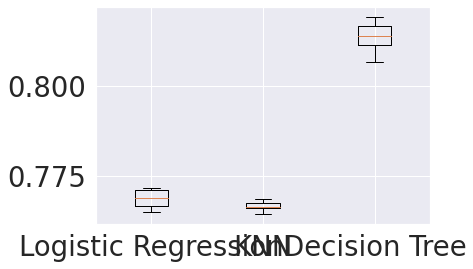

In [83]:
#Looping with cross validation the 3 models
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

#Plot with train results
plt.boxplot(results, labels=models.keys())
plt.show()

### COMPARING METRICS WITH OTHER MODELS

https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

https://towardsdatascience.com/machine-learning-experiment-tracking-93b796e501b0

This will run experiments for Logreg, RF, KNN, GaussianNB, XGBoost y ADA

In [84]:
final = run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

   malignant       0.75      1.00      0.86     16697
      benign       0.00      0.00      0.00      5578

    accuracy                           0.75     22275
   macro avg       0.37      0.50      0.43     22275
weighted avg       0.56      0.75      0.64     22275

RF
              precision    recall  f1-score   support

   malignant       0.90      0.94      0.92     16697
      benign       0.80      0.69      0.74      5578

    accuracy                           0.88     22275
   macro avg       0.85      0.81      0.83     22275
weighted avg       0.87      0.88      0.87     22275

KNN
              precision    recall  f1-score   support

   malignant       0.85      0.91      0.88     16697
      benign       0.65      0.52      0.57      5578

    accuracy                           0.81     22275
   macro avg       0.75      0.71      0.72     22275
weighted avg       0.80      0.81      0.80     22275

GNB
 

In [85]:
final.model.values

array(['LogReg', 'LogReg', 'LogReg', 'LogReg', 'LogReg', 'RF', 'RF', 'RF',
       'RF', 'RF', 'KNN', 'KNN', 'KNN', 'KNN', 'KNN', 'GNB', 'GNB', 'GNB',
       'GNB', 'GNB', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'ADA', 'ADA',
       'ADA', 'ADA', 'ADA'], dtype=object)

In [86]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics


## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')


## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

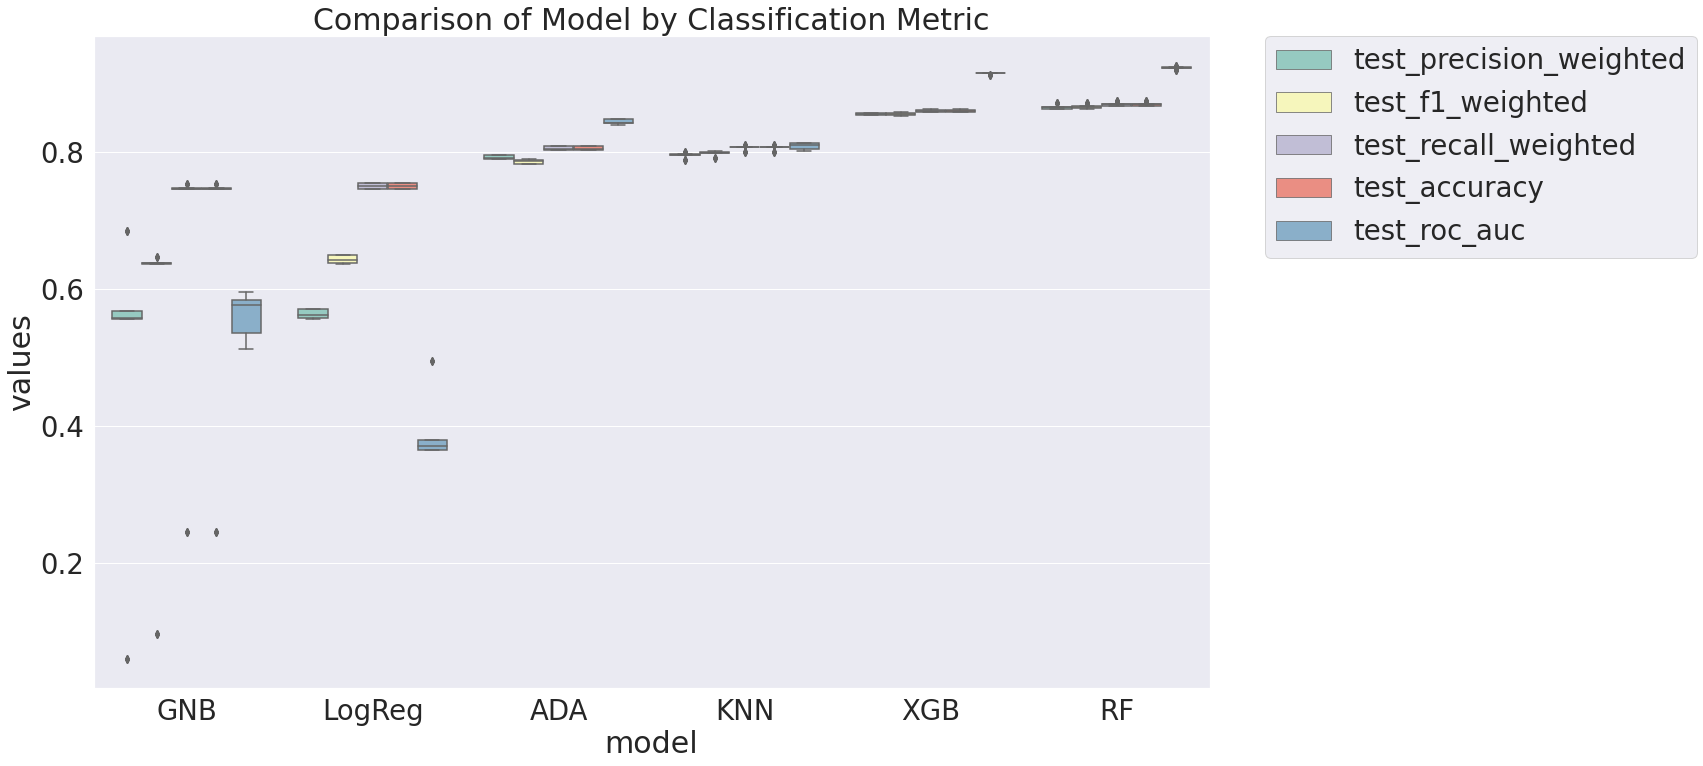

In [87]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

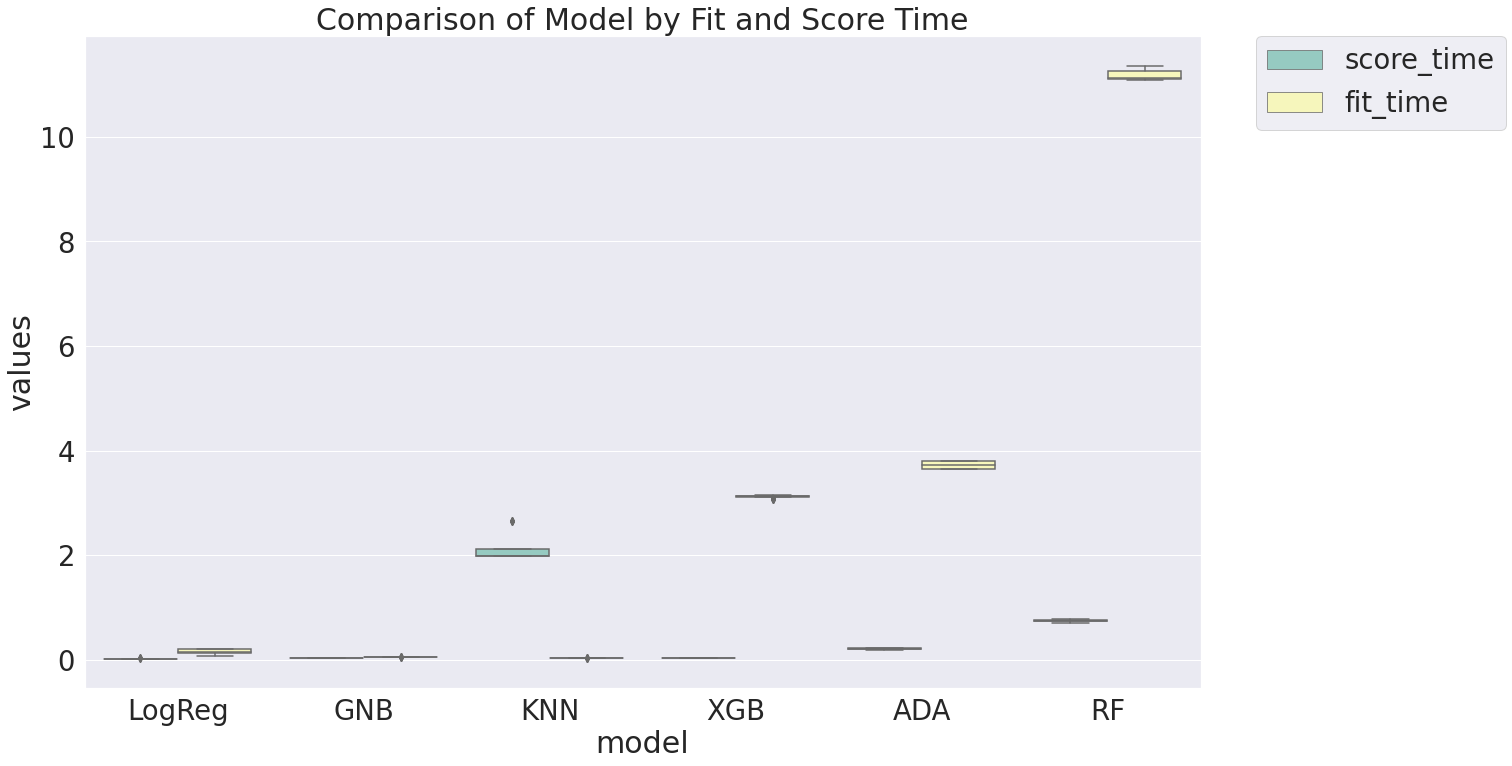

In [88]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [89]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_accuracy           test_recall_weighted           test_roc_auc  \
                 std      mean                  std      mean          std   
model                                                                        
ADA         0.002679  0.805972             0.002679  0.805972     0.003150   
GNB         0.190666  0.663975             0.190666  0.663975     0.030511   
KNN         0.003514  0.806785             0.003514  0.806785     0.004676   
LogReg      0.004054  0.750443             0.004054  0.750443     0.043166   
RF          0.002760  0.870404             0.002760  0.870404     0.001997   
XGB         0.001510  0.860725             0.001510  0.860725     0.001169   

                 test_precision_weighted           test_f1_weighted            
            mean                     std      mean              std      mean  
model                                                                          
ADA     0.844139                0.002439  0.792392         0.003161  0.786140  
GNB     0.562427                0.206784  0.501337         0.206078  0.549329  
KNN     0.809068                0.003761  0.796002         0.003570  0.798503  
LogReg  0.387047                0.006086  0.563180         0.005462  0.643460  
RF      0.923680                0.002895  0.866344         0.003006  0.866872  
XGB     0.915238                0.001554  0.855729         0.001945  0.856150

In [90]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time          
             std       mean        std      mean
model                                           
ADA     0.065694   3.725313   0.008619  0.205369
GNB     0.002206   0.054266   0.000723  0.031294
KNN     0.002957   0.034309   0.249216  2.125539
LogReg  0.042216   0.149700   0.001984  0.023267
RF      0.105022  11.182023   0.024988  0.741808
XGB     0.031015   3.124702   0.001092  0.036135

As expected, decision tree performs better. Let's move to this algorithms 

## DECISION TREE

#### DECISION TREE: GRIDSEARCH CV

In [91]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("tree", DecisionTreeClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"tree__max_depth": [4,8,12,14,16],
        "tree__criterion": ["gini", "entropy"],
        "tree__min_samples_leaf": [0.1, 0.5,1,2,4,6],
        "tree__max_features": ["sqrt", "log2"]
        }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Decision Tree Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test, y_test), recall_score(y_test, y_pred, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 1}, Acuraccy: 0.8201571268237935, Recall: 0.8201571268237935
All Parameters: {'cv': 10, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('tree', DecisionTreeClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__tree': DecisionTreeClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__tree__ccp_alpha': 0.0, 'estimator__tree__class_weight': None, 'estimator__tree__criterion': 'gini', 'estimator__tree__max_depth': None, 'estimator__tree__max_features': None, 'estimator__tree__max_leaf_nodes': None, 'estimator__tree__min_impurity_decrease': 0.0, 'estimator__tree__min_samples_leaf': 1, 'estimator__tree__min_samples_split': 2, 'estimator__tree__

V0 DATA: Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'entropy', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 4}, Acuraccy: 0.8323232323232324, Recall: 0.8323232323232324

V1 DATA: Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 6}, Acuraccy: 0.849023569023569, Recall: 0.849023569023569

V2 DATA: Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 1}, Acuraccy: 0.8201571268237935, Recall: 0.8201571268237935

#### DECISION TREE: FINAL MODEL SELECTED

In [92]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=16, random_state=1, criterion='gini', max_features='sqrt', min_samples_leaf=1)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)

dt.score(X_test, y_test)

dt.get_params()

df = pd.DataFrame({'pred': y_pred})

#### DECISION TREE: METRICS

#### ALL METRICS TOGETHER

### Confussion matrix: assessing clasification perfomance 

Accuraccy: sum of true predictions divided by total sum of the confussion matrix

Precision: VPP: number of true positives in all positive values - pacientes con prueba positiva, cuantos son verdaderos enfermos. High precision means low false positive rates. 

Recall: Sensitivity - number of true positive divided by sum of true positive and false negatives - pacientes enfermos, cuantos tienen prueba positiva.  High recall reflects a lower false negative rate. 

F1: Harmonic mean of precision and recall. Gives equal weight to precision and recall: favors models with similar metrics. 

Support: represents the number of instances for each class within the true labels.

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15279  1418]
 [ 2382  3196]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     16697
           1       0.69      0.57      0.63      5578

    accuracy                           0.83     22275
   macro avg       0.78      0.74      0.76     22275
weighted avg       0.82      0.83      0.82     22275



#### CONFUSSION MATRIX

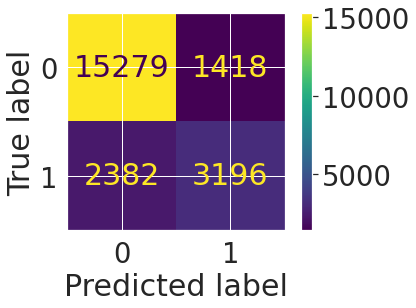

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

#### ROC AUC

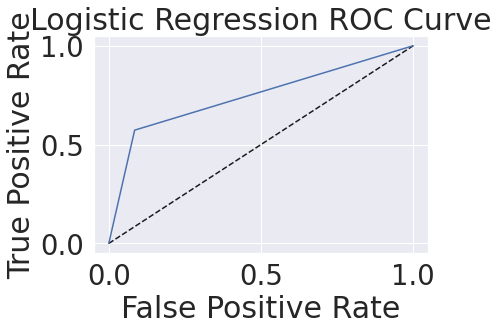

ROC under the curve is: 0.7440198924010649


In [95]:
y_score = dt.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC under the curve is: {auc}')

### FINAL PREDS TO EXPORT AND UPLOAD

In [96]:
#!cd /notebooks && mkdir predicts && cd predicts

In [97]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=16, random_state=1, criterion='gini', max_features='sqrt', min_samples_leaf=6)

# Fit dt to the training set
dt.fit(train.drop('target', axis = 1), train['target'])

# Predict test set labels
y_pred = dt.predict(test)

In [98]:
y_pred.shape

(65850,)

In [99]:
df_tree = pd.DataFrame({'pred': y_pred})
df_tree.to_csv('../notebooks/predicts/predictions_decision_tree_v3.csv', index=False)

## RANDOM FOREST

In [100]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("rfc", RandomForestClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 20, 30, 40, 50, None],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [200, 400, 600, 800, 1000]}


# Create the GridSearchCV object
tuning = RandomizedSearchCV(pipeline, param_distributions=params, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Random Forest Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test, y_test), recall_score(y_test, y_pred, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 600, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': 30, 'rfc__bootstrap': False}, Acuraccy: 0.8645566778900112, Recall: 0.8645566778900112
All Parameters: {'cv': 3, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__rfc': RandomForestClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__rfc__bootstrap': True, 'estimator__rfc__ccp_alpha': 0.0, 'estimator__rfc__class_weight': None, 'estimator__rfc__criterion': 'gini', 'estimator__rfc__max_depth': None, 'estimator__rfc__max_features': 'sqrt', 'estimator__rfc__max_leaf_nodes': None, 'estimator__rfc__max_samples': None, 'estimator__rfc__min_impurity_decrease': 0.0, 'estimator__rf

#### V0 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 800, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_features': 'auto', 'rfc__max_depth': 50, 'rfc__bootstrap': False}, Acuraccy: 0.8728619528619529, Recall: 0.8728619528619529

#### V1 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 600, 'rfc__min_samples_split': 10, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': None, 'rfc__bootstrap': False}, Acuraccy: 0.882020202020202, Recall: 0.882020202020202

#### V2 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 600, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': 30, 'rfc__bootstrap': False}, Acuraccy: 0.8645566778900112, Recall: 0.8645566778900112

#### MODEL SELECTED with metrics

In [102]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=False,
                            max_depth=30, 
                            max_features='sqrt', 
                            min_samples_leaf=1, 
                            min_samples_split=5, 
                            n_estimators=600, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

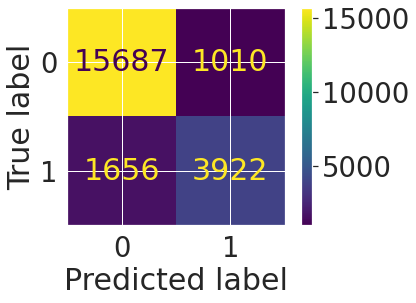

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

#### AUC-ROC

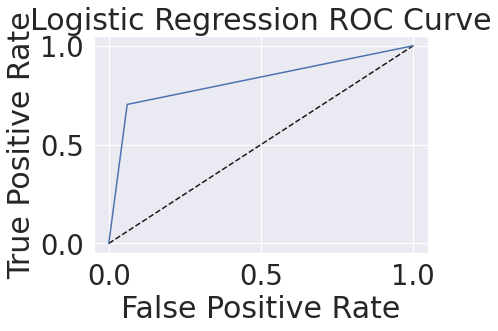

ROC under the curve is: 0.8213147446333939


In [104]:
y_score = rf.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC under the curve is: {auc}')

#### Feature importance

In [105]:
# Print how important each column is to the model
for i, item in enumerate(rf.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

lat: 0.08
lon: 0.08
surface_total: 0.12
pileta: 0.01
vigilancia: 0.01
patio: 0.01
garage: 0.01
balcon: 0.01
cancha: 0.01
gimnasio: 0.01
sauna: 0.01
a_estrenar: 0.00
days_published: 0.05
coast_dist: 0.09
d1: 0.08
d2: 0.08
d3: 0.10
d4: 0.08
property_type_Apartamento: 0.05
property_type_Casa: 0.02
property_type_Finca: 0.01
property_type_Local comercial: 0.00
property_type_Lote: 0.01
property_type_Oficina: 0.00
property_type_Otro: 0.03
property_type_Parqueadero: 0.00
bathrooms_cat_0: 0.01
bathrooms_cat_1: 0.01
bathrooms_cat_2: 0.00
bathrooms_cat_3: 0.01
bathrooms_cat_4: 0.01
bedrooms_cat_0: 0.01
bedrooms_cat_1: 0.01
bedrooms_cat_2: 0.01
bedrooms_cat_3: 0.01
bedrooms_cat_4: 0.01


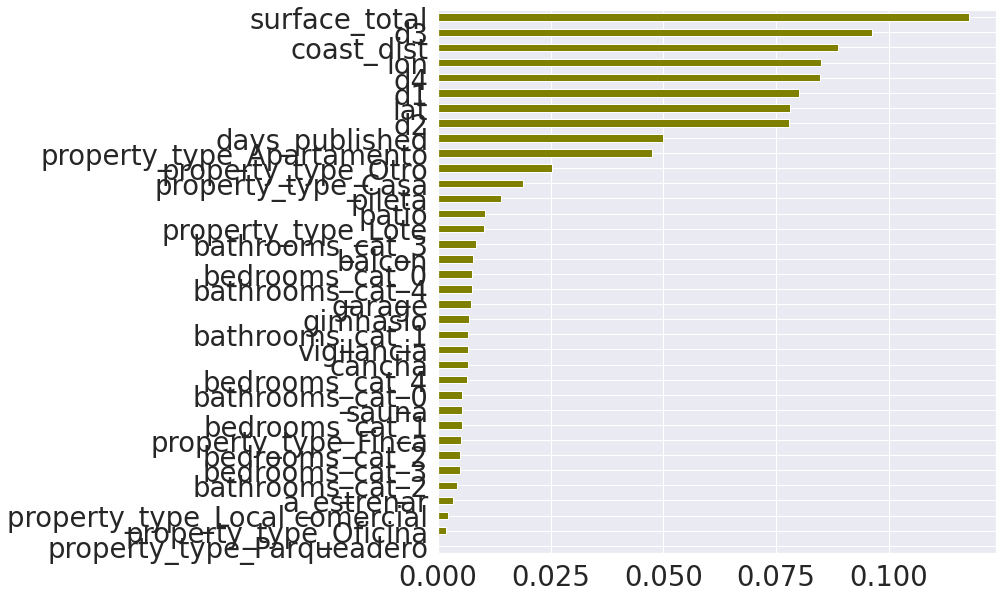

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = train.drop('target', axis=1).columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='olive', figsize=(10, 10))
plt.show()

As expected, with only superficie_total and a few position related features we can predict properties prices. 

In [107]:
from joblib import dump, load
dump(rf, './models/rf_full_v3.joblib') 

['./models/rf_full_v3.joblib']

## RANDOM FOREST with feature selection

In [13]:
tokeep_train = ['d1','d4','lon','surface_total','coast_dist','pileta','target']
tokeep_test = ['d1','d4','lon','surface_total','coast_dist','pileta']
train_less = train[tokeep_train]
test_less = test[tokeep_test]

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_less.drop('target', axis=1), train_less['target'], test_size=0.2, random_state=42, stratify=train_less['target'])

In [14]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("rfc", RandomForestClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 20, 30, 40, 50, None],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [200, 400, 600, 800, 1000]}


# Create the GridSearchCV object
tuning = RandomizedSearchCV(pipeline, param_distributions=params, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10)
tuning.fit(X_train1, y_train1)

y_pred1 = tuning.predict(X_test1)

# Compute and print performance
print("Tuned Random Forest Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test1, y_test1), recall_score(y_test1, y_pred1, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 800, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 2, 'rfc__max_depth': 30, 'rfc__bootstrap': True}, Acuraccy: 0.8274298540965208, Recall: 0.8274298540965208
All Parameters: {'cv': 3, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__rfc': RandomForestClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__rfc__bootstrap': True, 'estimator__rfc__ccp_alpha': 0.0, 'estimator__rfc__class_weight': None, 'estimator__rfc__criterion': 'gini', 'estimator__rfc__max_depth': None, 'estimator__rfc__max_features': 'sqrt', 'estimator__rfc__max_leaf_nodes': None, 'estimator__rfc__max_samples': None, 'estimator__rfc__min_impurity_decrease': 0.0, 'estimator__rfc

### V1 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 200, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': 50, 'rfc__bootstrap': True}, Acuraccy: 0.847003367003367, Recall: 0.847003367003367

### V2 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 800, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 2, 'rfc__max_depth': 30, 'rfc__bootstrap': True}, Acuraccy: 0.8274298540965208, Recall: 0.8274298540965208

### MINIMALIST MODEL DIAGNOSTICS

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True,
                            max_depth=30, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=5, 
                            n_estimators=800, 
                            random_state=123)

rf.fit(X_train1, y_train1)

y_pred1 = rf.predict(X_test1)

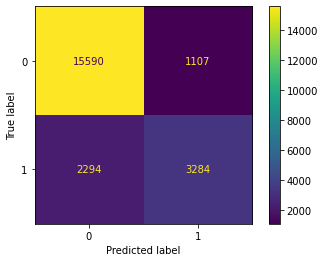

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test1, y_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

[[15590  1107]
 [ 2294  3284]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     16697
           1       0.75      0.59      0.66      5578

    accuracy                           0.85     22275
   macro avg       0.81      0.76      0.78     22275
weighted avg       0.84      0.85      0.84     22275



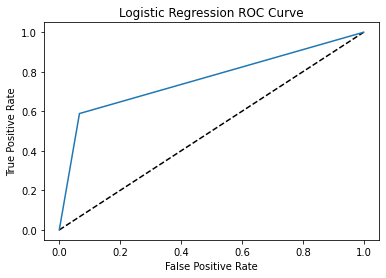

ROC under the curve is: 0.7612210745965471


In [18]:
y_score = rf.predict_proba(X_test1)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test1, y_pred1)
print(f'ROC under the curve is: {auc}')

In [56]:
from joblib import dump, load
dump(rf, './models/rf_minimalist_v3.joblib') 

['./models/rf_minimalist_v3.joblib']

Visualizing decision trees with Random Forest

https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7

[Text(0.5135361080864813, 0.9838709677419355, 'lon <= -74.119\ngini = 0.375\nsamples = 56435\nvalue = [66799, 22298]\nclass = t'),
 Text(0.22896870786326287, 0.9516129032258065, 'surface_total <= 145.44\ngini = 0.339\nsamples = 41325\nvalue = [51064, 14075]\nclass = t'),
 Text(0.05632094846378881, 0.9193548387096774, 'surface_total <= 26.889\ngini = 0.208\nsamples = 10318\nvalue = [14311, 1910]\nclass = t'),
 Text(0.026423997908444165, 0.8870967741935484, 'pileta <= 0.5\ngini = 0.484\nsamples = 1680\nvalue = [1558, 1088]\nclass = t'),
 Text(0.011872098310527488, 0.8548387096774194, 'surface_total <= 2.495\ngini = 0.463\nsamples = 1345\nvalue = [1340, 764]\nclass = t'),
 Text(0.005494961076865491, 0.8225806451612904, 'd4 <= 43.06\ngini = 0.495\nsamples = 469\nvalue = [411, 337]\nclass = t'),
 Text(0.0014782736417176402, 0.7903225806451613, 'surface_total <= 1.233\ngini = 0.477\nsamples = 109\nvalue = [70, 108]\nclass = a'),
 Text(0.0004548534282208124, 0.7580645161290323, 'coast_dist <=

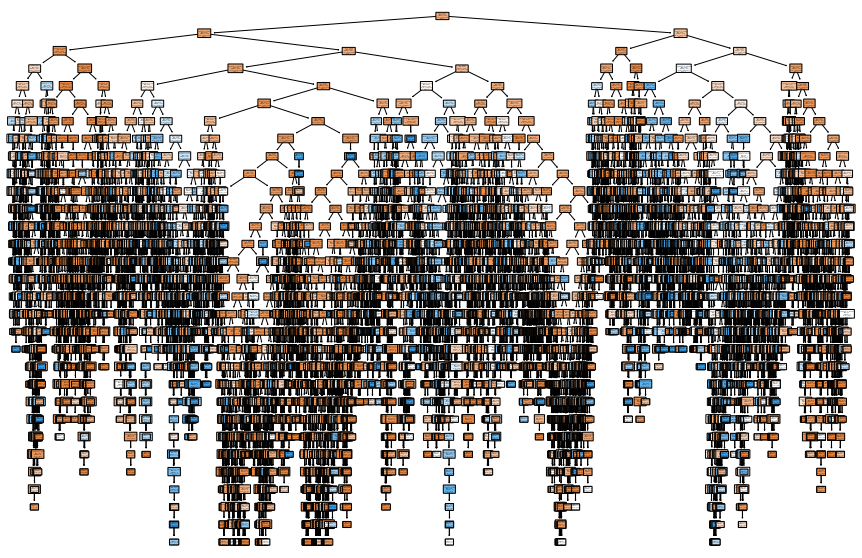

In [21]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], 
        feature_names=X_train1.columns.tolist(),
        class_names='target', 
        filled=True, impurity=True, 
        rounded=True)

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_small = RandomForestClassifier(bootstrap=True,
                            max_depth=4, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=5, 
                            n_estimators=100, 
                            random_state=123)

rf_small.fit(X_train1, y_train1)

y_pred1_small = rf_small.predict(X_test1)

In [31]:
print(classification_report(y_test1, y_pred1_small))
auc = roc_auc_score(y_test1, y_pred1)
print(f'ROC under the curve is: {auc}')

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     16697
           1       0.84      0.15      0.26      5578

    accuracy                           0.78     22275
   macro avg       0.81      0.57      0.56     22275
weighted avg       0.79      0.78      0.72     22275

ROC under the curve is: 0.7612210745965471


[Text(0.5, 0.9, 'lon <= -74.119\ngini = 0.375\nsamples = 56435\nvalue = [66799, 22298]\nclass = t'),
 Text(0.25, 0.7, 'surface_total <= 145.44\ngini = 0.339\nsamples = 41325\nvalue = [51064, 14075]\nclass = t'),
 Text(0.125, 0.5, 'surface_total <= 26.889\ngini = 0.208\nsamples = 10318\nvalue = [14311, 1910]\nclass = t'),
 Text(0.0625, 0.3, 'pileta <= 0.5\ngini = 0.484\nsamples = 1680\nvalue = [1558, 1088]\nclass = t'),
 Text(0.03125, 0.1, 'gini = 0.463\nsamples = 1345\nvalue = [1340, 764]\nclass = t'),
 Text(0.09375, 0.1, 'gini = 0.481\nsamples = 335\nvalue = [218, 324]\nclass = a'),
 Text(0.1875, 0.3, 'surface_total <= 120.095\ngini = 0.114\nsamples = 8638\nvalue = [12753, 822]\nclass = t'),
 Text(0.15625, 0.1, 'gini = 0.092\nsamples = 7661\nvalue = [11443, 583]\nclass = t'),
 Text(0.21875, 0.1, 'gini = 0.261\nsamples = 977\nvalue = [1310, 239]\nclass = t'),
 Text(0.375, 0.5, 'd4 <= 44.725\ngini = 0.374\nsamples = 31007\nvalue = [36753, 12165]\nclass = t'),
 Text(0.3125, 0.3, 'surface

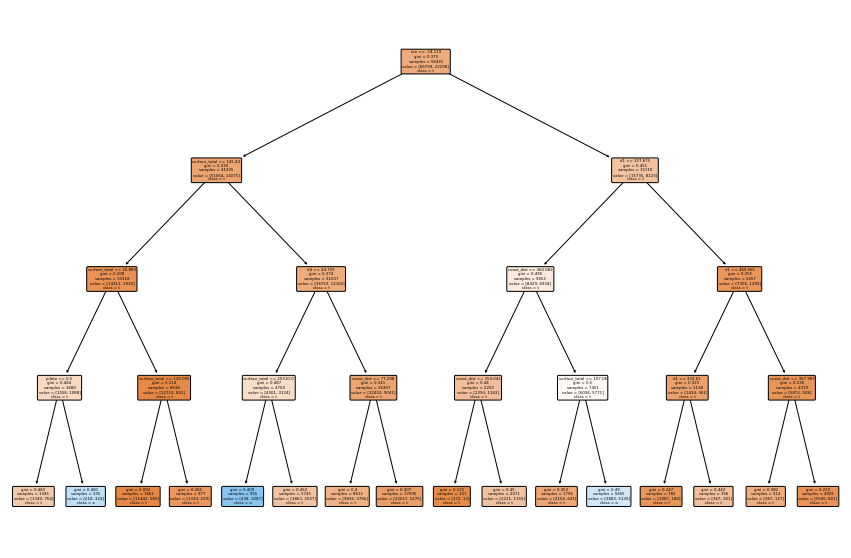

In [32]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf_small.estimators_[0], 
        feature_names=X_train1.columns.tolist(),
        class_names='target', 
        filled=True, impurity=True, 
        rounded=True)

In [ ]:
from sklearn.metrics import accuracy_score

scores =[]
for k in np.arange(1, 1000, 50):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train1, y_train1)
    y_pred = rfc.predict(X_test1)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Testing Accuracy')

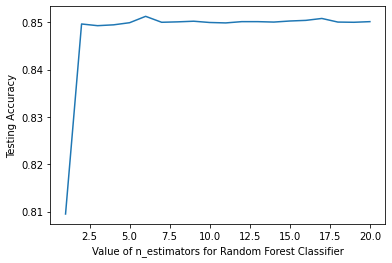

In [29]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 21), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

### FINAL MODEL TO EXPORT

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(bootstrap=True,
                            max_depth=30, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=5, 
                            n_estimators=800, 
                            random_state=123)

rf_final.fit(train_less.drop('target', axis =1), train_less['target'])

y_pred_rf_final = rf_final.predict(test_less)

In [33]:
y_pred_rf_final.shape

(65850,)

In [34]:
df_min = pd.DataFrame(y_pred_rf_final, columns=['pred'])
df_min.to_csv('predictions_random_forest_v4_minimalist.csv', index=False)

## XGBOOST

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 

gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
                'n_estimators': [10,20,50,100,200],
                'subsample': [0.3, 0.5, 0.9],
                'colsample_bytree_vals' : [0.1, 0.5, 0.8, 1],
                'max_depth': [2, 5, 10]
                }


gbm = xgb.XGBClassifier(objective='binary:logistic')

#grid_class = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid, scoring='accuracy', cv=3, verbose=1)
grid_class = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='accuracy', cv=3, verbose=1, n_iter=50, n_jobs=-1)

grid_class.fit(X_train, y_train)

print("Best parameters found: ",grid_class.best_params_)

print("Best accuracy found: ", grid_class.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[15:12:06] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:12:11] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:12:11] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but


Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.5}

Best accuracy found:  0.8805010269706051
Best parameters found:  {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.8}
Best accuracy found:  0.8820386769475964

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.1}
Best accuracy found:  0.8876729621069932

Best parameters found:  {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree_vals': 0.1}
Best accuracy found:  0.8642378531263679

In [36]:
# Split the data into training and test sets

xg_cl = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=100, 
                        seed=123,
                        learning_rate=0.5,
                        subsample=0.9,
                        colsample_bytree_vals=0.1,
                        max_depth=10)
                        
xg_cl.fit(X_train, y_train)

preds_xgb = xg_cl.predict(X_test)

[15:16:23] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




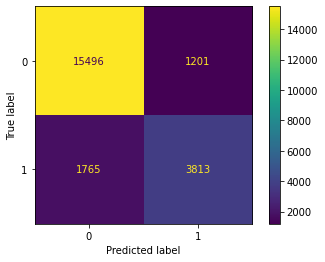

[[15496  1201]
 [ 1765  3813]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     16697
           1       0.76      0.68      0.72      5578

    accuracy                           0.87     22275
   macro avg       0.83      0.81      0.82     22275
weighted avg       0.86      0.87      0.86     22275



In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, preds_xgb)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, preds_xgb))
print(classification_report(y_test, preds_xgb))

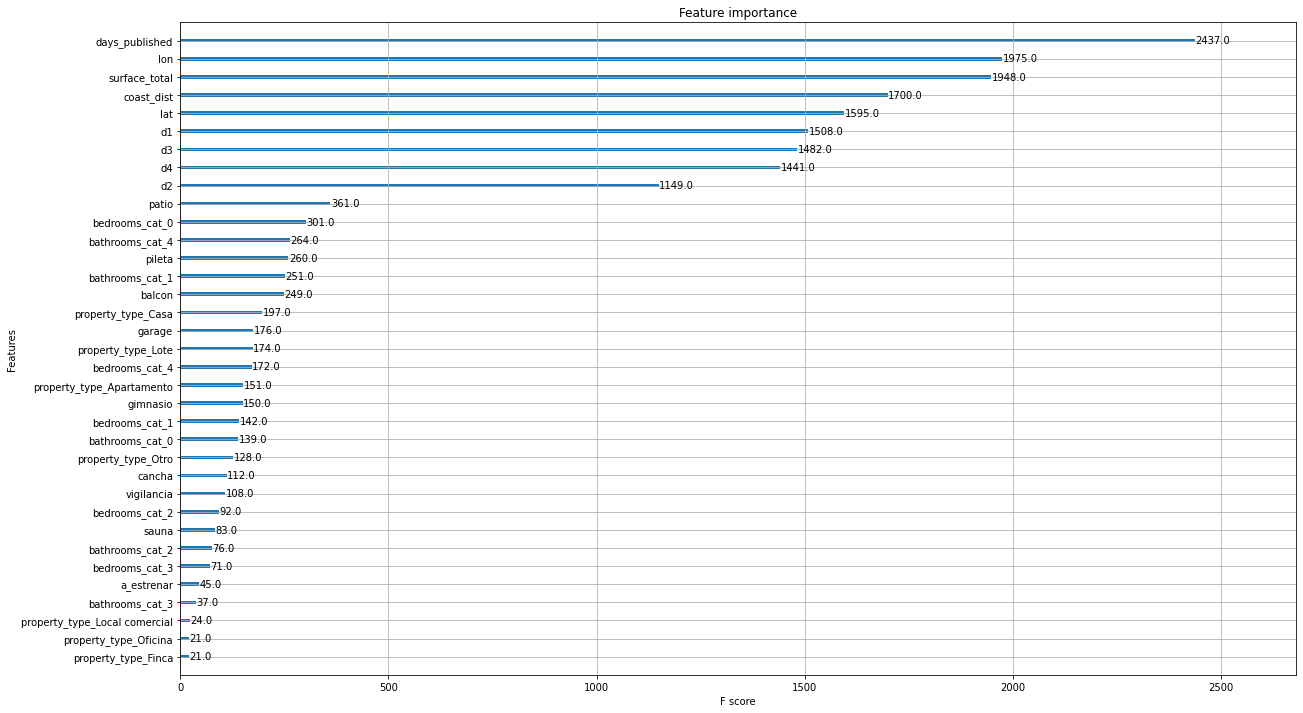

In [46]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(xg_cl, ax=ax)
plt.show()

In [57]:
from joblib import dump, load
dump(xg_cl, './models/xgb_v3.joblib') 

['./models/xgb_v3.joblib']

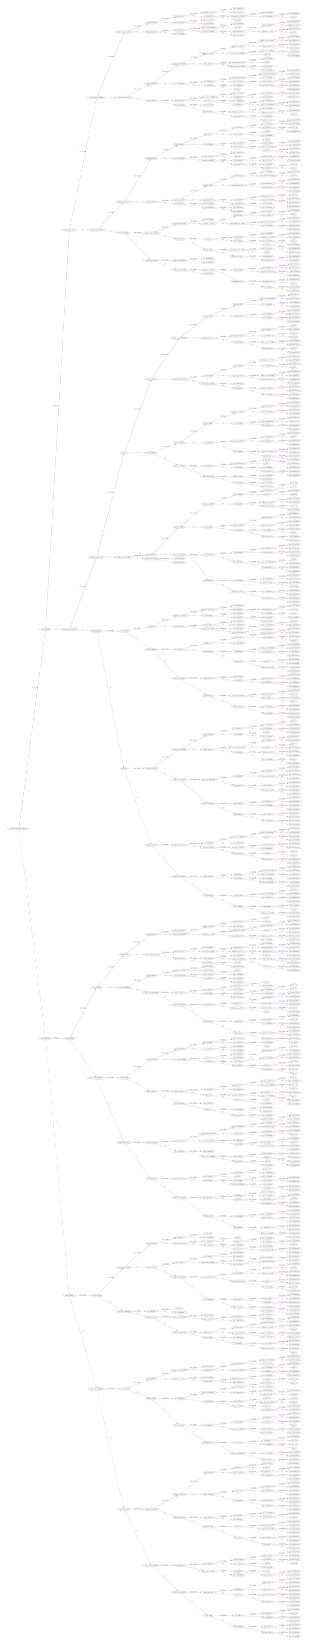

In [55]:
#!sudo add-apt-repository universe
#!sudo apt update
#!sudo apt install graphviz

fig, ax = plt.subplots(figsize=(30, 30))
# Plot the last tree sideways
xgb.plot_tree(xg_cl,num_trees = 0, rankdir = 'LR', ax=ax)
plt.show()

#### XGBoost with feature selection approach

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 

gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
                'n_estimators': [10,20,50,100,200],
                'subsample': [0.3, 0.5, 0.9],
                'colsample_bytree_vals' : [0.1, 0.5, 0.8, 1],
                'max_depth': [2, 5, 10]
                }


gbm = xgb.XGBClassifier(objective='binary:logistic')

#grid_class = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid, scoring='accuracy', cv=3, verbose=1)
grid_class = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='accuracy', cv=5, verbose=1, n_iter=100, n_jobs=-1)

grid_class.fit(X_train1, y_train1)

print("Best parameters found: ",grid_class.best_params_)

print("Best accuracy found: ", grid_class.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[00:16:06] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:16:09] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:16:12] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree_vals': 1}
Best accuracy found:  0.8619032805812834

In [ ]:
# Split the data into training and test sets

xg_cl_min = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=200, 
                        seed=123,
                        learning_rate=0.5,
                        subsample=0.9,
                        colsample_bytree_vals=1,
                        max_depth=10)
                        
xg_cl_min.fit(X_train1, y_train1)

preds_xgb_min = xg_cl_min.predict(X_test1)

[00:27:23] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




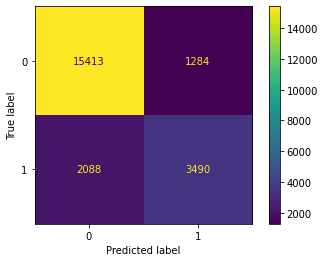

[[15413  1284]
 [ 2088  3490]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     16697
           1       0.73      0.63      0.67      5578

    accuracy                           0.85     22275
   macro avg       0.81      0.77      0.79     22275
weighted avg       0.84      0.85      0.84     22275



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test1, preds_xgb_min)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1, preds_xgb_min))
print(classification_report(y_test1, preds_xgb_min))

### VISUALIZING INDIVIDUAL TREES

In [ ]:
# Plot the last tree sideways
xgb.plot_tree(xg_cl_min,num_trees = 9, rankdir = 'LR')
plt.show()

#### FINAL MODEL TO EXPORT

In [ ]:
# Split the data into training and test sets

xg_cl_2 = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=200, 
                        seed=123,
                        learning_rate=0.1,
                        subsample=0.9,
                        colsample_bytree_vals=0.1,
                        max_depth=10)
                        
xg_cl_2.fit(train_less.drop('target', axis=1), train_less['target'])

preds_xgb_2 = xg_cl_2.predict(test_less)

[00:27:34] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
df = pd.DataFrame(preds_xgb_2, columns=['pred'])
df.to_csv('../notebooks/predicts/predictions_xgboost_v1_minimalist.csv', index=False)